In [1]:
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
plt.style.use('ggplot')

# Data import

In [2]:
raw_data = pd.read_json("all_scripts_raw.json")
raw_data.head()

,DS9,TOS,TAS,TNG,VOY,ENT
episode 0,\n\n\n\n\n\nThe Deep Space Nine Transcripts - ...,\n\n\n\n\n\nThe Star Trek Transcripts - The Ca...,\n\n\n\n\n\nThe Animated Star Trek Transcripts...,\n\n\n\n\n\nThe Next Generation Transcripts - ...,\n\n\n\n\nThe Voyager Transcripts - Caretaker\...,\n\n\n\n\n\nThe Enterprise Transcripts - Broke...
episode 1,\n\n\n\n\n\nThe Deep Space Nine Transcripts - ...,\n\n\n\n\n\nThe Star Trek Transcripts - The Ma...,\n\n\n\n\n\nThe Animated Star Trek Transcripts...,\n\n\n\n\n\nThe Next Generation Transcripts - ...,\n\n\n\n\n\nThe Voyager Transcripts - Parallax...,\n\n\n\n\n\nThe Enterprise Transcripts - Fight...
episode 2,\n\n\n\n\n\nThe Deep Space Nine Transcripts - ...,\n\n\n\n\n\nThe Star Trek Transcripts - Charli...,\n\n\n\n\n\nThe Animated Star Trek Transcripts...,\n\n\n\n\n\nThe Next Generation Transcripts - ...,\n\n\n\n\n\nThe Voyager Transcripts - Time and...,\n\n\n\n\n\nThe Enterprise Transcripts - Stran...
episode 3,\n\n\n\n\n\nThe Deep Space Nine Transcripts - ...,\n\n\n\n\n\nThe Star Trek Transcripts - Where ...,\n\n\n\n\n\nThe Animated Star Trek Transcripts...,\n\n\n\n\n\nThe Next Generation Transcripts - ...,\n\n\n\n\n\n\nThe Voyager Transcripts - Phage\...,\n\n\n\n\n\nThe Enterprise Transcripts - Unexp...
episode 4,\n\n\n\n\n\nThe Deep Space Nine Transcripts - ...,\n\n\n\n\n\nThe Star Trek Transcripts - The Na...,\n\n\n\n\n\nThe Animated Star Trek Transcripts...,\n\n\n\n\n\nThe Next Generation Transcripts - ...,\n\n\n\n\n\nThe Voyager Transcripts - The Clou...,\n\n\n\n\n\nThe Enterprise Transcripts - Terra...


In [3]:
episodes_raw = raw_data['TOS'].keys()
series_lines_raw = raw_data['TOS']

In [18]:
print(type(series_lines_raw))

<class 'pandas.core.series.Series'>


In [4]:
episodes_raw

Index(['episode 0', 'episode 1', 'episode 2', 'episode 3', 'episode 4',
       'episode 5', 'episode 6', 'episode 7', 'episode 8', 'episode 9',
       ...
       'episode 166', 'episode 167', 'episode 168', 'episode 169',
       'episode 170', 'episode 171', 'episode 172', 'episode 173',
       'episode 174', 'episode 175'],
      dtype='object', length=176)

## Cleaning

In [5]:
series_lines_raw = series_lines_raw.dropna()

In [19]:
series_lines_raw_df = pd.DataFrame(series_lines_raw)
series_lines_raw_df

,TOS
episode 0,\n\n\n\n\n\nThe Star Trek Transcripts - The Ca...
episode 1,\n\n\n\n\n\nThe Star Trek Transcripts - The Ma...
episode 2,\n\n\n\n\n\nThe Star Trek Transcripts - Charli...
episode 3,\n\n\n\n\n\nThe Star Trek Transcripts - Where ...
episode 4,\n\n\n\n\n\nThe Star Trek Transcripts - The Na...
...,...
episode 75,\n\n\n\n\n\nThe Star Trek Transcripts - The Wa...
episode 76,\n\n\n\n\n\nThe Star Trek Transcripts - The Cl...
episode 77,\n\n\n\n\n\nThe Star Trek Transcripts - The Sa...
episode 78,\n\n\n\n\n\nThe Star Trek Transcripts - All Ou...


In [20]:
%store series_lines_raw_df

Stored 'series_lines_raw_df' (DataFrame)


Cleanign the data. I want to get the text in such a way that I see:

CHARACTER: And their lines.
ANOTHERCHARACTER: And the dialogue from another character. 

So this will have each line as the name of the character in all caps, a colon, and their spoken words. Each line is separated by a newline. 

In [7]:
pd.DataFrame(series_lines_raw).shape

(80, 1)

In [6]:


def clean_episode(episode_text):
    if isinstance(episode_text, str):
        # Remove text at the beginning of each episode
        cleaned = re.sub("(The Star Trek Transcripts(.|\n)*?)([A-Z' ]+:+)", r"\3", episode_text)

        # Remove text at the end of each episode
        cleaned = re.sub("<Back(.|\n)*", "", cleaned)

        # Remove instances of " [OC]", denoting when a character is speaking off-camera.
        cleaned = cleaned.replace(" [OC]", "")

        # Remove any descriptions of the scene, which are surrounded by [] and () parentheses.
        cleaned = re.sub(" ?[\(\[](.|\n)*?[\)\]]", "", cleaned)

        # Remove non-breaking space characters
        cleaned = cleaned.replace('\u00a0', '');

        # Remove multiple instances of '\n'.
        cleaned = cleaned.replace('\n \n', '\n');
        cleaned = re.sub("(\n)+", "\n", cleaned)
        
        # Remove multiple instances of ':'.
        cleaned = cleaned.replace('::', ':');

        # Remove lines starting with "Captain's log", etc. They don't include data on who spoke them.
        cleaned = re.sub("((Captain's [Ll]og|Ship's [Ll]og|First [Oo]fficer's [Ll]og|Enterprise [Ll]og)(.|\n)*?)([A-Z' ]+:)", r"\4", cleaned)

        # Remove newlines that are in the middle of a spoken line
        cleaned = re.sub("(?<! )\n(?!([A-Z' ]*?:))", " ", cleaned)
        
        # Remove any leading and trailing spaces/newlines
        cleaned = cleaned.strip()

        return cleaned
    
    else:
        return episode_text  # Return as is if it's not a string

In [9]:
#series_lines_raw[80]

In [7]:
# Clean all episodes
series_lines_clean = []
for i,ep in enumerate(series_lines_raw):
    series_lines_clean.append(clean_episode(series_lines_raw[i]))

In [21]:
series_lines_clean_df = pd.DataFrame(series_lines_clean)
%store series_lines_clean_df

Stored 'series_lines_clean_df' (DataFrame)


In [13]:
# print("★★★★★ ORIGINAL ★★★★★")
# print(series_lines_raw[1][0:301])
# print("\n★★★★★ CLEANED ★★★★★")
# print(series_lines_clean[1][0:301])

## Exploration and analysis

Now I want to group lines by character.

In [8]:
# A function that takes one variable as input:
#    - episode_text: All lines in one episode. Formatted such that every line is
#                    the name of the character in all caps, a colon, and the line.
#                    Each line starts on a newline.
# Returns one variable:
#    - a dictionary, where the key is the character name, and the value is an array
#      of lines spoken by that character
def group_by_character(episode_text):
    if isinstance(episode_text, str):
        lines_by_character = {}
        # Each spoken line is separated by a newline
        split_lines = episode_text.split('\n')

        for line in split_lines:
            # A name is in all caps (and can have an apostrophe, or a space), followed by a colon
            name = re.search("([A-Z' ]+)(?=:+)", line)
            # The spoken words follow the colon
            words = re.search("(?<=:)(.*)", line)
            if name is not None:
                name = name.group(0).strip()
                words = words.group(0).strip()
                if name in lines_by_character.keys():
                    lines_by_character[name].append(words)
                else:
                    lines_by_character[name]=[words]
        return lines_by_character
    else:
        return {}  # Return an empty dictionary if it's not a string

In [9]:
# Group the lines by character for every episode
series_lines_by_character = []
for i,ep in enumerate(series_lines_clean):
    series_lines_by_character.append(group_by_character(series_lines_clean[i]))

In [10]:
series_lines_by_character_df = pd.DataFrame(series_lines_by_character)


In [16]:
%store series_lines_by_character_df

Stored 'series_lines_by_character_df' (DataFrame)


In [11]:
series_lines_by_character_df.head()

,SPOCK,TYLER,ONE,PIKE,GARISON,BOYCE,COLT,GEOLOGIST,PITCAIRN,OLD MAN,...,ATOZ,WENCH,LAW,ZARABETH,JUDGE,JAILOR,COLEMAN,JANICE,LYSA,LEMLI
0,"[Check the circuit., It can't be the screen th...","[All operating, sir., It could be these meteor...","[No, it's something else. There's still someth...","[Steady as we go., They were keyed to cause in...","[It's a radio wave, sir. We're passing through...","[I understand we picked up a distress signal.,...","[Yes, sir., But you wanted the reports by oh f...","[Geological lab report complete, Captain., Our...","[Yes, sir. There's a canyon to the left. We ca...",[They're men. They're humans.],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Miss Uhura, your last sub-space log contained...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[That is a very intriguing question. Scanners ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[Your move, Captain., I'll have you checkmated...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[Check out the life-support systems., Someone ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
def word_line_counts(series_lines, episode_list, use_episode_name_as_index):
    total_word_counts={}
    total_line_counts={}
    for i,ep in enumerate(episode_list):
        # Different datasets require different index types
        if use_episode_name_as_index:
            index = ep
        else:
            index = i
        if series_lines[index] is not np.NaN:
            for member in list(series_lines[index].keys()):
                total_words_by_member_in_ep = sum([len(line.split()) for line in series_lines[index][member]])
                total_lines_by_member_in_ep = len(series_lines[index][member])
                if member in total_word_counts.keys():
                    total_word_counts[member]=total_word_counts[member]+total_words_by_member_in_ep
                    total_line_counts[member]=total_line_counts[member]+total_lines_by_member_in_ep
                else:
                    total_word_counts[member]=total_words_by_member_in_ep
                    total_line_counts[member]=total_lines_by_member_in_ep
    return total_word_counts, total_line_counts

In [13]:
def graph_word_line_counts(word_counts, line_counts):
    # Place the figures side-by-side
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    
    # Changes the colors of the bars
    bar_cmap = plt.get_cmap("Set2")

    # Plot number of words
    words_df=pd.DataFrame(list(word_counts.items()), columns=['Character','No. of Words'])
    most_words=words_df.sort_values(by='No. of Words', ascending=False).head(25)
    most_words.plot.bar(x='Character',y='No. of Words', ax=ax1, color=bar_cmap.colors)

    # Plot number of lines
    lines_df=pd.DataFrame(list(line_counts.items()), columns=['Character','No. of Lines'])
    most_lines=lines_df.sort_values(by='No. of Lines', ascending=False).head(25)
    most_lines.plot.bar(x='Character',y='No. of Lines', ax=ax2, color=bar_cmap.colors)
    plt.show()

In [14]:
plt.style.use('ggplot')

Cleaned graphs


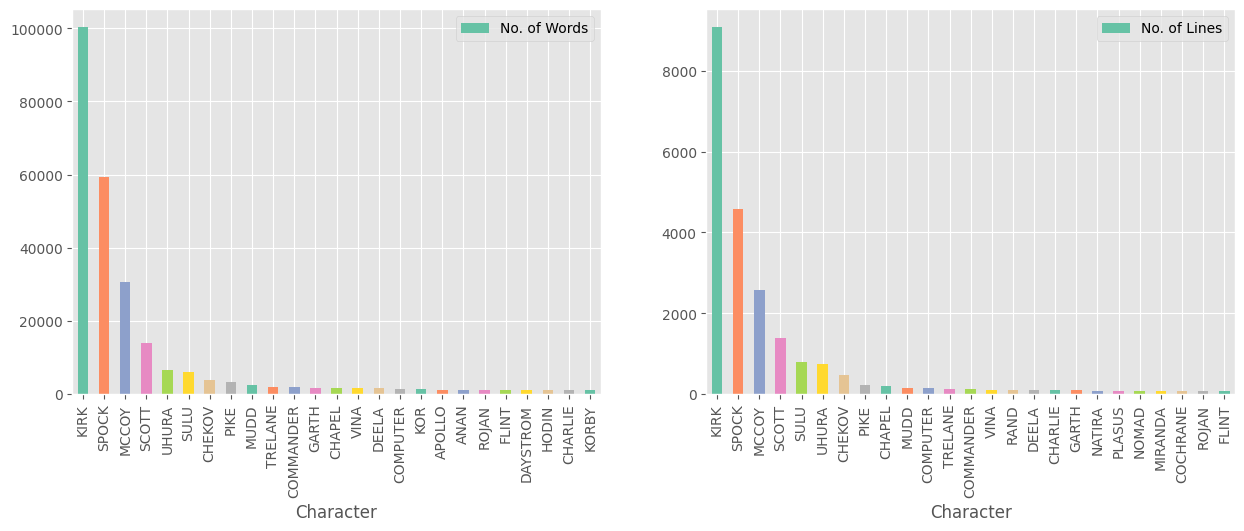

In [15]:
print("Cleaned graphs")
clean_word_counts, clean_line_counts = word_line_counts(series_lines_by_character, series_lines_by_character, False)
graph_word_line_counts(clean_word_counts, clean_line_counts)

## Sentiment

In [21]:
import nltk

In [22]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [23]:
characters_of_interest = ['SPOCK', 'KIRK', 'MCCOY']

# Create dictionaries to store sentiment scores for each character and episode
sentiment_scores = {char: {'episode': [], 'overall': []} for char in characters_of_interest}


In [24]:
char_lines = pd.DataFrame(series_lines_by_character)
char_lines.head()

,SPOCK,TYLER,ONE,PIKE,GARISON,BOYCE,COLT,GEOLOGIST,PITCAIRN,OLD MAN,...,ATOZ,WENCH,LAW,ZARABETH,JUDGE,JAILOR,COLEMAN,JANICE,LYSA,LEMLI
0,"[Check the circuit., It can't be the screen th...","[All operating, sir., It could be these meteor...","[No, it's something else. There's still someth...","[Steady as we go., They were keyed to cause in...","[It's a radio wave, sir. We're passing through...","[I understand we picked up a distress signal.,...","[Yes, sir., But you wanted the reports by oh f...","[Geological lab report complete, Captain., Our...","[Yes, sir. There's a canyon to the left. We ca...",[They're men. They're humans.],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Miss Uhura, your last sub-space log contained...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[That is a very intriguing question. Scanners ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[Your move, Captain., I'll have you checkmated...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[Check out the life-support systems., Someone ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
three_char = char_lines[characters_of_interest]
filtered_episodes = three_char.dropna(how='all')
filtered_episodes

,SPOCK,KIRK,MCCOY
0,"[Check the circuit., It can't be the screen th...",NaN,NaN
1,"[Miss Uhura, your last sub-space log contained...","[Shall we pick some flowers, Doctor? When a ma...","[Is that how you get girls to like you, by bri..."
2,[That is a very intriguing question. Scanners ...,"[All right, Chief, begin materialisation.\r Ca...",[Tell me. The ship's supply of food\r concentr...
3,"[Your move, Captain., I'll have you checkmated...",[We should have intercepted by now. The Bridge...,NaN
4,"[Check out the life-support systems., Someone ...","[Kirk, affirmative., What caused it?, Captain ...","[You're fine, Joe. Up and out of there.\r Mist..."
...,...,...,...
75,"[It is definitely the stolen space cruiser, Ca...","[Hailing frequencies. Aurora, this is the USS ...",[Trouble. Your friend here didn't want a check...
76,"[It is, Captain., They've already been provide...","[At Federation orders, we're\r proceeding at t...","[That may not be easy, Jim. Medical analysis i..."
77,[I still read a suggestion of carbon cycle lif...,"[Spock, any answers?, Which is scientifically ...",[What's all this poppycock about life forms on...
78,[The power source we detected is in this build...,"[Any sign of survivors?, If they knew that the...",[How can a planet full of people just disappea...


In [26]:
from nltk.tokenize import word_tokenize


In [27]:
word_counts = {char: {'episode': []} for char in characters_of_interest}


In [28]:
# Iterate through the characters of interest
for char in characters_of_interest:
    # Extract the lines spoken by the character and store them in a Series
    character_lines = filtered_episodes[char].fillna("").astype(str)  # Ensure lines are treated as strings
    
    # Perform sentiment analysis on the character's lines
    sentiment_scores[char]['episode'] = character_lines.apply(lambda x: sia.polarity_scores(x)['compound'])
    
    # Tokenize the character's lines and calculate the number of words
    word_counts[char]['episode'] = character_lines.apply(lambda x: len(word_tokenize(x)))

# Convert sentiment_scores to a DataFrame for easy analysis and visualization
sentiment_df = pd.DataFrame(sentiment_scores)

# Display the sentiment analysis results
# print(sentiment_df)

In [51]:
sentiment_df

,SPOCK,KIRK,MCCOY
episode,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...,0 0.0000 1 0.9957 2 0.9965 3 0...,0 0.0000 1 0.7874 2 0.9415 3 0...
overall,[],[],[]


In [29]:
spock_scores = pd.DataFrame(sentiment_scores['SPOCK']['episode'], columns=['SPOCK'])
kirk_scores = pd.DataFrame(sentiment_scores['KIRK']['episode'], columns=['KIRK'])
mccoy_scores = pd.DataFrame(sentiment_scores['MCCOY']['episode'], columns=['MCCOY'])

# Concatenate the DataFrames along the columns axis
merged_df = pd.concat([spock_scores, kirk_scores, mccoy_scores], axis=1)
merged_df

,SPOCK,KIRK,MCCOY
0,-0.6641,0.0000,0.0000
1,-0.9900,0.9957,0.7874
2,-0.9457,0.9965,0.9415
3,-0.8881,0.9917,0.0000
4,0.9743,0.9606,-0.4213
...,...,...,...
75,-0.9693,0.9934,0.7456
76,-0.9787,0.9939,0.3504
77,0.9643,0.9758,0.8351
78,-0.8361,0.7055,-0.9790


In [30]:
spock_words = pd.DataFrame(word_counts['SPOCK']['episode'], columns=['SPOCK'])
kirk_words = pd.DataFrame(word_counts['KIRK']['episode'], columns=['KIRK'])
mccoy_words = pd.DataFrame(word_counts['MCCOY']['episode'], columns=['MCCOY'])

# Concatenate the DataFrames along the columns axis
word_counts_df = pd.concat([spock_words, kirk_words, mccoy_words], axis=1)
word_counts_df

,SPOCK,KIRK,MCCOY
0,488,0,0
1,679,1827,1217
2,533,2093,413
3,863,1695,0
4,1291,1454,540
...,...,...,...
75,956,1476,419
76,1195,2106,280
77,866,1750,462
78,1567,1358,931


In [31]:
average_scores = merged_df.mean()

# Print the average scores
print(average_scores)

SPOCK   -0.005304
KIRK     0.224218
MCCOY    0.104833
dtype: float64


In [32]:
average_words = word_counts_df.mean()

# Print the average scores
print(average_words)

SPOCK    1040.4000
KIRK     1873.2875
MCCOY     573.1125
dtype: float64


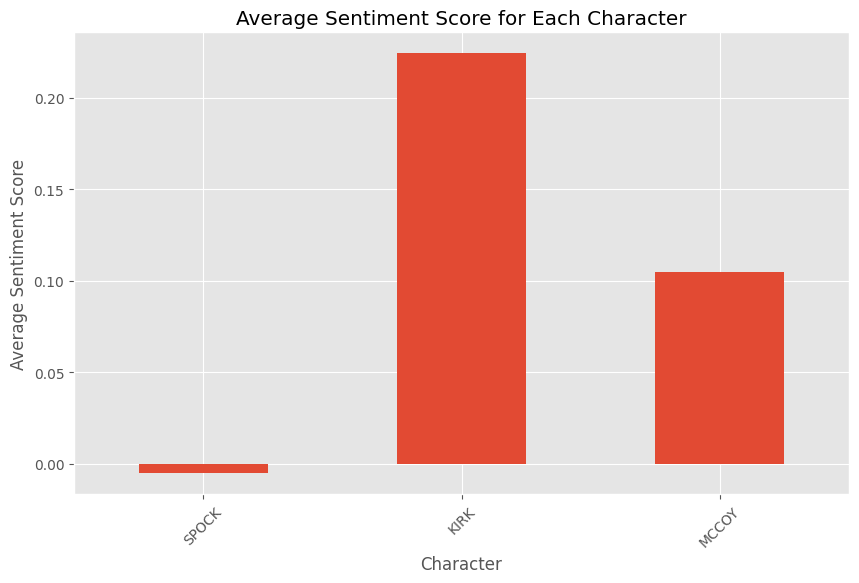

In [33]:
plt.figure(figsize=(10, 6))
average_scores.plot(kind='bar')
plt.xlabel('Character')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score for Each Character')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Trying weighted by words.

In [34]:
len(word_counts_df)

80

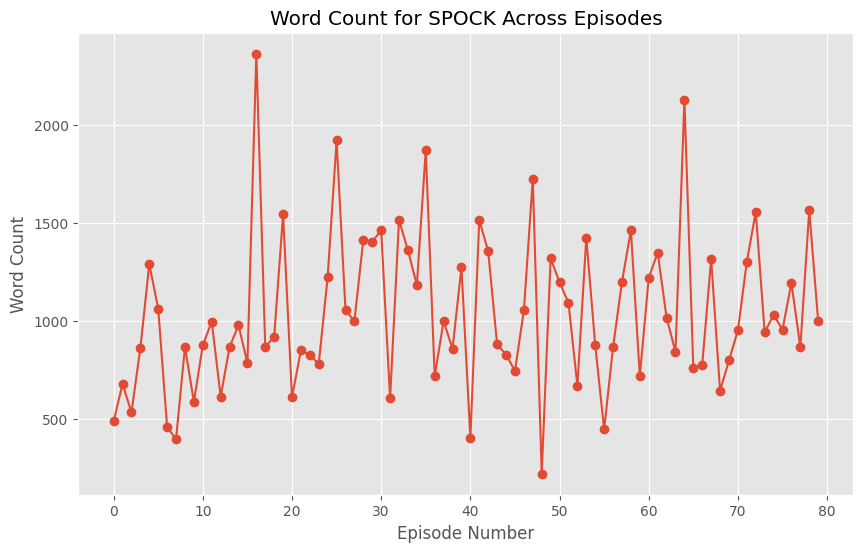

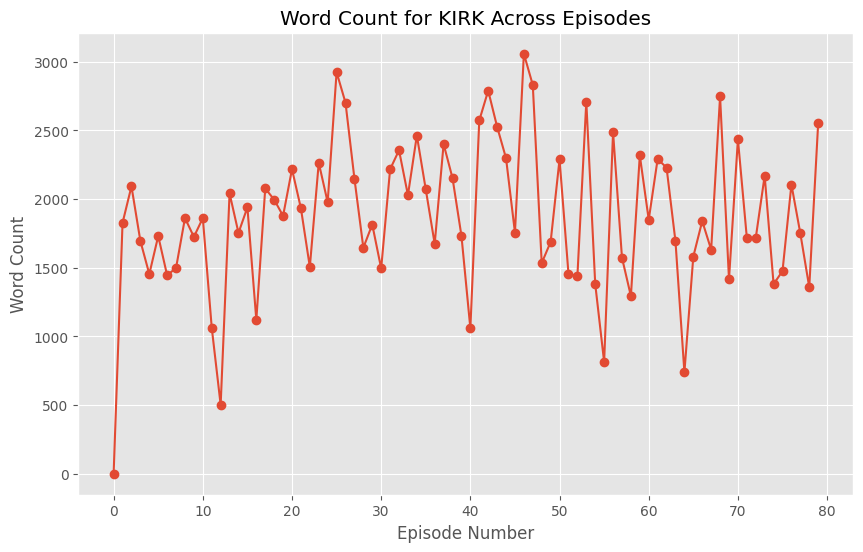

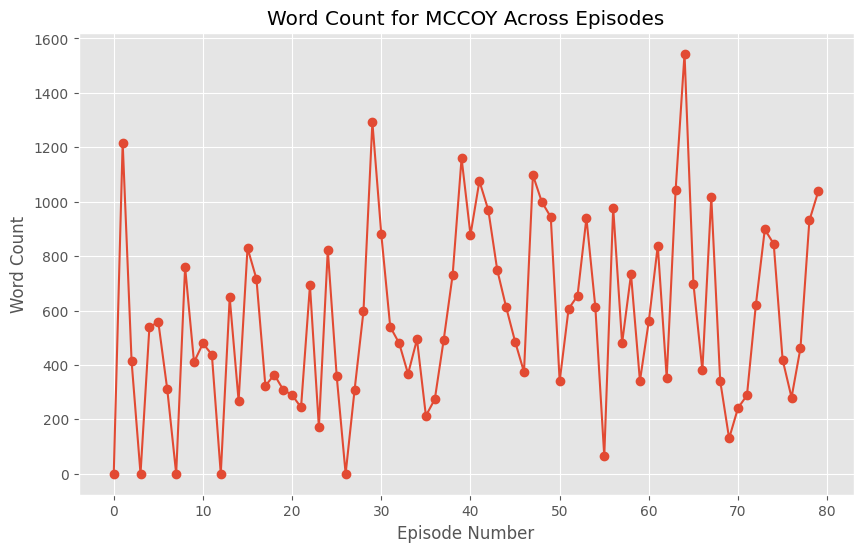

In [35]:
for char in characters_of_interest:
    plt.figure(figsize=(10, 6))
    episode_numbers = range(len(word_counts_df))
    plt.plot(episode_numbers, word_counts_df[char], marker='o', label=char)
    plt.title(f'Word Count for {char} Across Episodes')
    plt.xlabel('Episode Number')
    plt.ylabel('Word Count')
    #plt.legend()
    plt.grid(True)
    plt.show()

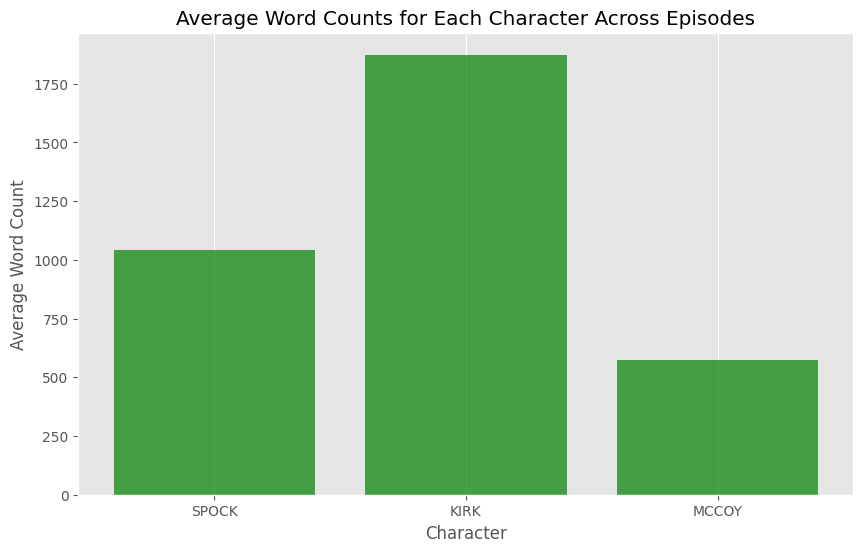

In [36]:
# Calculate and compare the average word counts for each character
average_word_counts = {char: sum(word_counts[char]['episode']) / len(word_counts[char]['episode']) for char in characters_of_interest}

plt.figure(figsize=(10, 6))
plt.bar(average_word_counts.keys(), average_word_counts.values(), color='green', alpha=0.7)
plt.title('Average Word Counts for Each Character Across Episodes')
plt.xlabel('Character')
plt.ylabel('Average Word Count')
plt.grid(axis='y')
plt.show()

In [37]:
for char in characters_of_interest:
    # Merge sentiment scores and word counts per character per episode
    char_data = pd.merge(pd.DataFrame(sentiment_scores[char]['episode']), pd.DataFrame(word_counts[char]), left_index=True, right_index=True)


char_data

,MCCOY,episode
0,0.0000,0
1,0.7874,1217
2,0.9415,413
3,0.0000,0
4,-0.4213,540
...,...,...
75,0.7456,419
76,0.3504,280
77,0.8351,462
78,-0.9790,931


In [38]:
sentiment_scores[char]['episode'] 

0     0.0000
1     0.7874
2     0.9415
3     0.0000
4    -0.4213
       ...  
75    0.7456
76    0.3504
77    0.8351
78   -0.9790
79    0.9017
Name: MCCOY, Length: 80, dtype: float64

In [39]:
sentiment_df['KIRK']

episode    0     0.0000
1     0.9957
2     0.9965
3     0...
overall                                                   []
Name: KIRK, dtype: object

In [40]:
test = pd.merge(sentiment_df['KIRK'], word_counts_df['KIRK'], left_index=True, right_index=True)
test

,KIRK_x,KIRK_y


In [42]:
test = pd.DataFrame(word_counts['KIRK'])
test

,episode
0,0
1,1827
2,2093
3,1695
4,1454
...,...
75,1476
76,2106
77,1750
78,1358


In [43]:
for char in characters_of_interest:
    # Merge sentiment scores and word counts per character per episode
    scores = pd.DataFrame(sentiment_scores[char])
    counts = pd.DataFrame(word_counts[char]) 
    # char_data = pd.merge(scores['episode'], counts, left_index=True, right_index=True)
    # char_data.columns = ['sent_per_episode', 'word count']


counts

ValueError: array length 0 does not match index length 80

In [ ]:
    scores = pd.DataFrame(sentiment_scores[char])

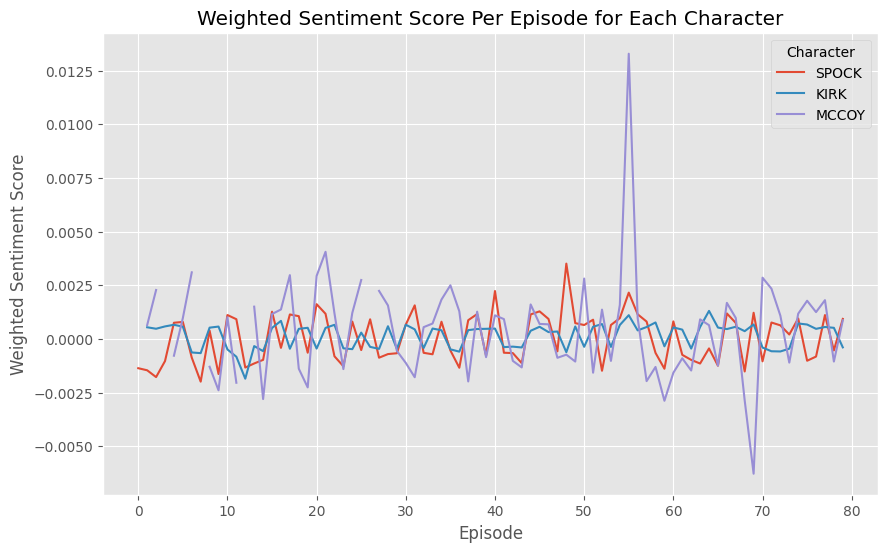

In [59]:
weighted_sentiment_per_episode = {}
for char in characters_of_interest:
    # Merge sentiment scores and word counts per character per episode
    # scores = pd.DataFrame(sentiment_scores[char])
    counts = pd.DataFrame(word_counts[char]) 
    char_data = pd.merge(merged_df[char], counts, left_index=True, right_index=True)
    char_data.columns = ['sent_per_episode', 'word count']
    
    
    # Calculate weighted sentiment score per episode
    weighted_sentiment_per_episode[char] = char_data['sent_per_episode'] / char_data['word count']

# Convert dictionary to DataFrame
weighted_sentiment_per_episode_df = pd.DataFrame(weighted_sentiment_per_episode)

# Plot weighted sentiment per episode for each character
weighted_sentiment_per_episode_df.plot.line(figsize=(10, 6))
plt.xlabel('Episode')
plt.ylabel('Weighted Sentiment Score')
plt.title('Weighted Sentiment Score Per Episode for Each Character')
plt.legend(title='Character')
plt.show()

In [60]:
import plotly.graph_objs as go

# Initialize a list to store Plotly traces
traces = []

for char in characters_of_interest:
    # Merge sentiment scores and word counts per character per episode
    # scores = pd.DataFrame(sentiment_scores[char])
    counts = pd.DataFrame(word_counts[char]) 
    char_data = pd.merge(merged_df[char], counts, left_index=True, right_index=True)
    char_data.columns = ['sent_per_episode', 'word count']
    
    # Calculate weighted sentiment score per episode
    weighted_sentiment_per_episode[char] = char_data['sent_per_episode'] / char_data['word count']

    # Create a Plotly trace for the character
    trace = go.Scatter(
        x=char_data.index,  # Episode numbers
        y=weighted_sentiment_per_episode[char],
        mode='lines+markers',
        name=char
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Weighted Sentiment Score Per Episode for Each Character',
    xaxis=dict(title='Episode'),
    yaxis=dict(title='Weighted Sentiment Score')
)

# Create the Plotly figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()


In [65]:
merged_df.iloc[54:56] # .split('\n')[5]

,SPOCK,KIRK,MCCOY
54,0.8513,0.9000,0.9727
55,0.9623,0.9017,0.8500


In [72]:
word_counts_df.iloc[54:56] 

,SPOCK,KIRK,MCCOY
54,878,1382,612
55,446,814,64


Maybe weighting by sentiment is not a good thing because low word counts can amplify sentiment scores.

In [ ]:
episode_names = []

# Iterate through each row in series_lines_raw
for episode_text in series_lines_raw:
    # Split the first line of the episode text by '\n' and extract the episode name
    episode_name = episode_text.split('\n')# [4]  # Adjust the index based on the position of the episode name
    episode_names.append(episode_name)

# Print the extracted episode names
episode_names

In [ ]:
sentiment_scores['SPOCK']

{'episode': 0    -0.6641
 1    -0.9900
 2    -0.9457
 3    -0.8881
 4     0.9743
        ...  
 75   -0.9693
 76   -0.9787
 77    0.9643
 78   -0.8361
 79    0.9326
 Name: SPOCK, Length: 80, dtype: float64,
 'overall': -0.005303749999999992}

In [ ]:
spock_sent = pd.DataFrame(sentiment_scores['SPOCK'])

In [ ]:
#spock_sent = spock_sent.drop(['overall'], axis=1)
#spock_sent.reset_index(inplace=True)

spock_sent


,episode,overall
0,-0.6641,-0.005304
1,-0.9900,-0.005304
2,-0.9457,-0.005304
3,-0.8881,-0.005304
4,0.9743,-0.005304
...,...,...
75,-0.9693,-0.005304
76,-0.9787,-0.005304
77,0.9643,-0.005304
78,-0.8361,-0.005304


In [ ]:
kirk_sent = pd.DataFrame(sentiment_scores['KIRK'])
# kirk_sent = kirk_sent.drop(['overall'], axis=1)
# kirk_sent.columns = ['KIRK']
kirk_sent

,episode,overall
0,0.0000,0.224218
1,0.9957,0.224218
2,0.9965,0.224218
3,0.9917,0.224218
4,0.9606,0.224218
...,...,...
75,0.9934,0.224218
76,0.9939,0.224218
77,0.9758,0.224218
78,0.7055,0.224218


In [ ]:
mccoy_sent = pd.DataFrame(sentiment_scores['MCCOY'])
# mccoy_sent = mccoy_sent.drop(['overall'], axis=1)
# mccoy_sent.columns = ['MCCOY']
mccoy_sent

,episode,overall
0,0.0000,0.104833
1,0.7874,0.104833
2,0.9415,0.104833
3,0.0000,0.104833
4,-0.4213,0.104833
...,...,...
75,0.7456,0.104833
76,0.3504,0.104833
77,0.8351,0.104833
78,-0.9790,0.104833


In [ ]:
result_df  

In [ ]:
result_df = pd.concat([spock_sent['episode'], kirk_sent['episode'], mccoy_sent['episode']], axis=1)

# Rename the columns if needed
result_df.columns = ['Spock', 'Kirk', 'McCoy']

# Display the resulting DataFrame
result_df

,Spock,Kirk,McCoy
0,-0.6641,0.0000,0.0000
1,-0.9900,0.9957,0.7874
2,-0.9457,0.9965,0.9415
3,-0.8881,0.9917,0.0000
4,0.9743,0.9606,-0.4213
...,...,...,...
75,-0.9693,0.9934,0.7456
76,-0.9787,0.9939,0.3504
77,0.9643,0.9758,0.8351
78,-0.8361,0.7055,-0.9790


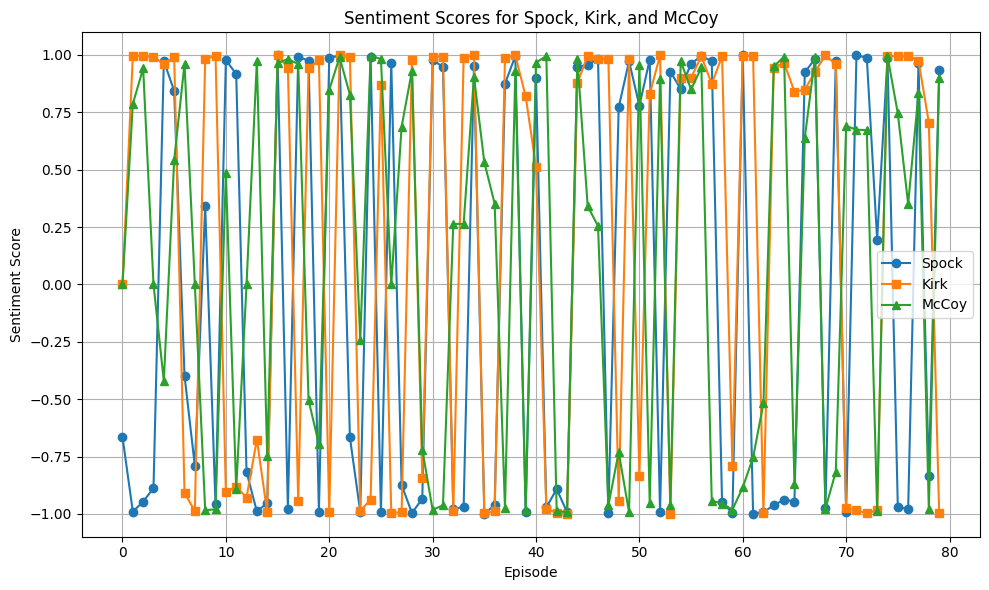

In [ ]:
plt.figure(figsize=(10, 6))  
plt.plot(result_df['Spock'], label='Spock', marker='o')
plt.plot(result_df['Kirk'], label='Kirk', marker='s')
plt.plot(result_df['McCoy'], label='McCoy', marker='^')

plt.xlabel('Episode')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores for Spock, Kirk, and McCoy')

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

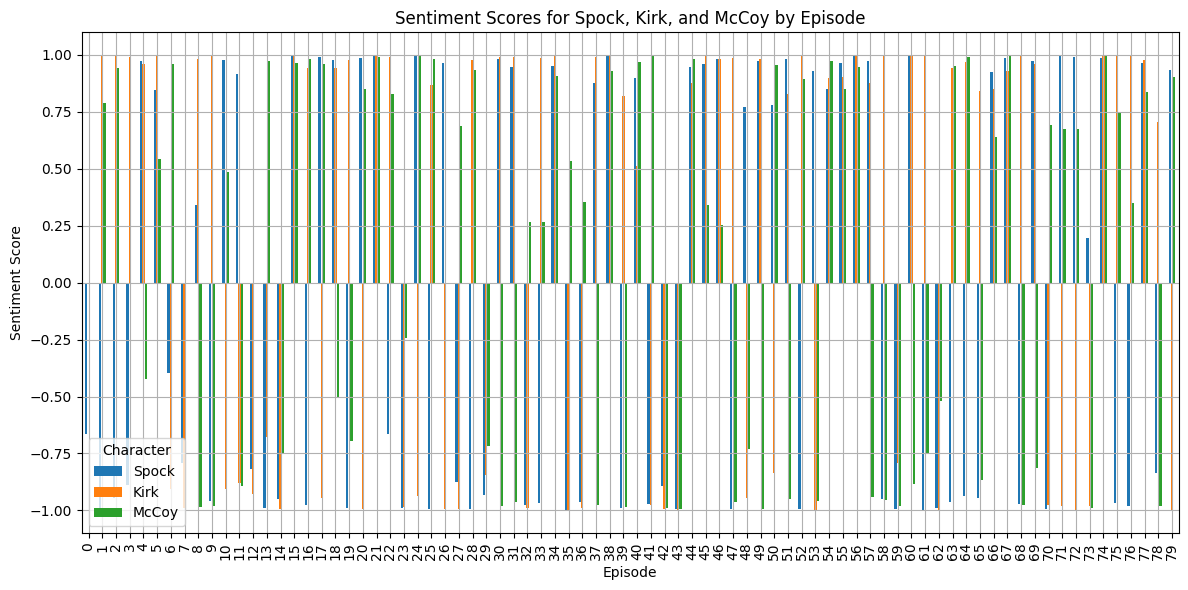

In [ ]:
result_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Episode')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores for Spock, Kirk, and McCoy by Episode')
plt.legend(title='Character')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#series_lines_clean

In [ ]:
series_for_sent = pd.DataFrame(series_lines_clean)


,0
0,SPOCK: Check the circuit. \r\nTYLER: All opera...
1,"KIRK: Shall we pick some flowers, Doctor? When..."
2,"KIRK: All right, Chief, begin materialisation...."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should..."
4,SPOCK: Check out the life-support systems. \r\...
...,...
171,NaN
172,NaN
173,NaN
174,NaN


In [ ]:
series_for_sent = series_for_sent.dropna()
series_for_sent

,0
0,SPOCK: Check the circuit. \r\nTYLER: All opera...
1,"KIRK: Shall we pick some flowers, Doctor? When..."
2,"KIRK: All right, Chief, begin materialisation...."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should..."
4,SPOCK: Check out the life-support systems. \r\...
...,...
75,SPOCK: It is definitely the stolen space cruis...
76,"KIRK: At Federation orders, we're\r proceeding..."
77,"SULU: All observation stations, take final\r r..."
78,SPOCK: The power source we detected is in this...


In [ ]:
series_for_sent.columns = ['episode']

In [ ]:
series_for_sent

,episode
0,SPOCK: Check the circuit. \r\nTYLER: All opera...
1,"KIRK: Shall we pick some flowers, Doctor? When..."
2,"KIRK: All right, Chief, begin materialisation...."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should..."
4,SPOCK: Check out the life-support systems. \r\...
...,...
75,SPOCK: It is definitely the stolen space cruis...
76,"KIRK: At Federation orders, we're\r proceeding..."
77,"SULU: All observation stations, take final\r r..."
78,SPOCK: The power source we detected is in this...


In [ ]:
def calculate_sentiment(line):
    return sia.polarity_scores(line)['compound']


In [73]:
# Apply sentiment analysis to each row (episode) and accumulate the sentiment scores
series_for_sent['cumulative_sentiment'] = series_for_sent['episode'].apply(lambda x: [calculate_sentiment(line) for line in x.split('\n') if line.strip()])

# Plot the change in sentiment through each episode
plt.figure(figsize=(12, 6))
for idx, row in series_for_sent.iterrows():
    plt.plot(row['cumulative_sentiment'], label=f'Episode {idx}')

plt.xlabel('Line Number')
plt.ylabel('Cumulative Sentiment Score')
plt.title('Change in Sentiment Through Each Episode')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'series_for_sent' is not defined

In [ ]:
series_for_sent

,episode,cumulative_sentiment
0,SPOCK: Check the circuit. \r\nTYLER: All opera...,"[0.0, 0.0, 0.4019, 0.0, -0.296, -0.3612, 0.0, ..."
1,"KIRK: Shall we pick some flowers, Doctor? When...","[0.3612, 0.3612, 0.0, -0.4696, 0.4215, 0.0, 0...."
2,"KIRK: All right, Chief, begin materialisation....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.802, 0.8176, 0.831..."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should...","[0.0, 0.0, 0.0, -0.2247, -0.0772, 0.5862, 0.0,..."
4,SPOCK: Check out the life-support systems. \r\...,"[0.0, 0.0, -0.5423, -0.6486, 0.0, -0.033, 0.0,..."
...,...,...
75,SPOCK: It is definitely the stolen space cruis...,"[-0.1027, 0.0, 0.0, -0.296, -0.4215, 0.0, 0.0,..."
76,"KIRK: At Federation orders, we're\r proceeding...","[0.2023, 0.3612, 0.0, 0.0, -0.34, 0.0, 0.0, 0...."
77,"SULU: All observation stations, take final\r r...","[0.0, 0.0, 0.0, 0.0, 0.2732, 0.0, 0.0, -0.5719..."
78,SPOCK: The power source we detected is in this...,"[0.0, 0.0, -0.296, -0.2263, -0.6705, 0.25, 0.3..."


In [ ]:
#series_for_sent[1][1]

KeyError: 1

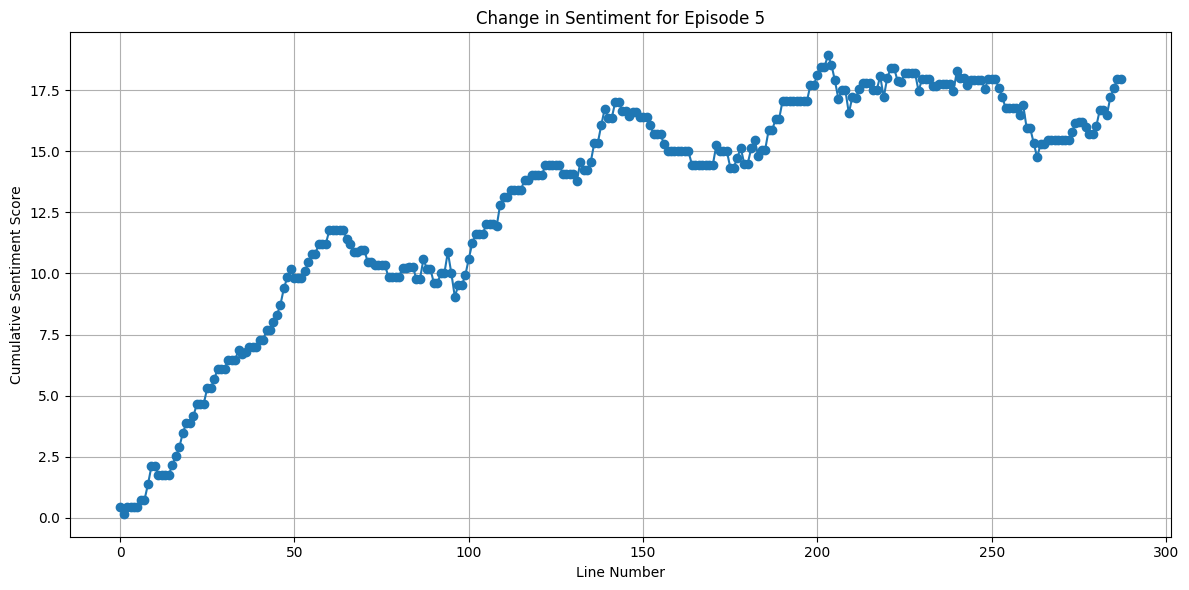

In [ ]:
# Select the specific episode you want to analyze (e.g., Episode 5)
episode_to_analyze = 5
selected_episode = series_for_sent.loc[episode_to_analyze, 'episode']

# Apply sentiment analysis and accumulate the sentiment scores for the selected episode
cumulative_sentiment = []
for line in selected_episode.split('\n'):
    line = line.strip()
    if line:
        sentiment_score = calculate_sentiment(line)
        if cumulative_sentiment:
            sentiment_score += cumulative_sentiment[-1]
        cumulative_sentiment.append(sentiment_score)

# Plot the change in sentiment for the selected episode
plt.figure(figsize=(12, 6))
plt.plot(cumulative_sentiment, marker='o')

plt.xlabel('Line Number')
plt.ylabel('Cumulative Sentiment Score')
plt.title(f'Change in Sentiment for Episode {episode_to_analyze}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # Use 'TkAgg' or another appropriate backend

from matplotlib.animation import FuncAnimation


In [ ]:
# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))

# Function to update the plot for each episode
def update(frame):
    ax.clear()
    episode = series_for_sent.loc[frame, 'episode']
    cumulative_sentiment = []
    for line in episode.split('\n'):
        line = line.strip()
        if line:
            sentiment_score = calculate_sentiment(line)
            if cumulative_sentiment:
                sentiment_score += cumulative_sentiment[-1]
            cumulative_sentiment.append(sentiment_score)
    ax.plot(cumulative_sentiment, marker='o')
    ax.set_xlabel('Line Number')
    ax.set_ylabel('Cumulative Sentiment Score')
    ax.set_title(f'Change in Sentiment for Episode {frame}')
    ax.grid(True)

# Define the range of episodes to display (e.g., the first 5 episodes)
episode_range = range(5)

# Create the animation
animation = FuncAnimation(fig, update, frames=episode_range, repeat=False)

plt.show()

In [ ]:
animation.save('sentiment_animation.mp4', writer='ffmpeg')

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [ ]:
sentiment_scores

In [ ]:
df = pd.DataFrame(sentiment_scores)
df.reset_index(inplace=True)

# Rename the columns for clarity
df.columns = ['episode', 'Spock', 'Kirk', 'McCoy']
df

,episode,Spock,Kirk,McCoy
0,episode,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...,0 0.0000 1 0.9957 2 0.9965 3 0...,0 0.0000 1 0.7874 2 0.9415 3 0...
1,overall,-0.005304,0.224218,0.104833


In [ ]:
sentiment_df

,SPOCK,KIRK,MCCOY
episode,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...,0 0.0000 1 0.9957 2 0.9965 3 0...,0 0.0000 1 0.7874 2 0.9415 3 0...
overall,-0.005304,0.224218,0.104833


In [ ]:
sentiment_df_reset = sentiment_df.reset_index()

# Use the 'melt' function to reshape the DataFrame
melted_sentiment_df = pd.melt(sentiment_df_reset, id_vars='index', var_name='character', value_name='sentiment_score')

# Rename the columns for clarity
melted_sentiment_df.columns = ['episode', 'character', 'sentiment_score']

# Display the reformatted DataFrame
melted_sentiment_df

,episode,character,sentiment_score
0,episode,SPOCK,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...
1,overall,SPOCK,-0.005304
2,episode,KIRK,0 0.0000 1 0.9957 2 0.9965 3 0...
3,overall,KIRK,0.224218
4,episode,MCCOY,0 0.0000 1 0.7874 2 0.9415 3 0...
5,overall,MCCOY,0.104833


In [ ]:
# Reset the index to make 'character' a regular column
sentiment_df_reset = sentiment_df.reset_index()

# Use the 'stack' function to unstack the DataFrame
unstacked_sentiment_df = sentiment_df_reset.set_index('index').stack().reset_index()

# Rename the columns for clarity
unstacked_sentiment_df.columns = ['character', 'episode', 'sentiment_score']

# Display the reformatted DataFrame
unstacked_sentiment_df

,character,episode,sentiment_score
0,episode,SPOCK,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...
1,episode,KIRK,0 0.0000 1 0.9957 2 0.9965 3 0...
2,episode,MCCOY,0 0.0000 1 0.7874 2 0.9415 3 0...
3,overall,SPOCK,-0.005304
4,overall,KIRK,0.224218
5,overall,MCCOY,0.104833


In [ ]:
# Create a new DataFrame where each row represents an episode
episode_sentiment_df = sentiment_df.copy()
episode_sentiment_df.reset_index(inplace=True)

# Melt the DataFrame to have sentiment scores for each episode in separate rows
melted_episode_sentiment_df = episode_sentiment_df.melt(id_vars='index', var_name='character', value_name='sentiment_score')
melted_episode_sentiment_df.columns = ['episode', 'character', 'sentiment_score']

# Display the reformatted DataFrame
melted_episode_sentiment_df

,episode,character,sentiment_score
0,episode,SPOCK,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...
1,overall,SPOCK,-0.005304
2,episode,KIRK,0 0.0000 1 0.9957 2 0.9965 3 0...
3,overall,KIRK,0.224218
4,episode,MCCOY,0 0.0000 1 0.7874 2 0.9415 3 0...
5,overall,MCCOY,0.104833


In [ ]:
# Iterate through episodes and lines grouped by character
for episode_lines_by_character in asdf:
    # Iterate through the characters of interest (Spock, Kirk, McCoy)
    for char in characters_of_interest:
        # Check if the character is in the lines for the current episode
        if char in episode_lines_by_character:
            # Get the lines spoken by the character (already combined into a single string)
            character_lines = episode_lines_by_character[char]
            
            # Perform sentiment analysis on the character's lines
            sentiment = sia.polarity_scores(character_lines)
            
            # Append sentiment scores for the current episode
            sentiment_scores[char]['episode'].append(sentiment['compound'])


AttributeError: 'list' object has no attribute 'encode'

In [ ]:
for episode in data[:5]:  # Print the first 5 episodes as an example
    print(episode)

TypeError: unhashable type: 'slice'

In [ ]:
# Process each line of dialogue
for episode in data:
    for line in episode['lines']:
        character = line['character']
        text = line['text']
        sentiment = sia.polarity_scores(text)
        
        if character == 'Spock':
            spock_sentiment['episode'].append(sentiment['compound'])
        elif character == 'Kirk':
            kirk_sentiment['episode'].append(sentiment['compound'])
        elif character == 'Bones':
            bones_sentiment['episode'].append(sentiment['compound'])

TypeError: string indices must be integers, not 'str'